# Exploratory data analysis

### Chapters:
* [How to import our dataset](#How-to-import-our-dataset)
* [Summarize our dataset](#Summarize-our-dataset)
* [Slicing and subsetting our dataset](#Slicing-and-subsetting-our-dataset)
* [How to plot using Pandas](#How-to-plot-using-Pandas)

## How to import our dataset

Our data set is already prepared in a csv format.

In [1]:
# import what we need
import os
import glob
from ast import literal_eval
import json
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')
%matplotlib inline  

In [2]:
BASE = os.path.dirname(os.path.dirname(os.path.dirname(os.path.abspath(__name__))))

In [3]:
BASE

'/Users/christianbarra/Projects/pybootcamp/workshops/pandas-on-jupyter'

In [4]:
folder = os.path.join(BASE, "data/cleaned")

In [5]:
folder

'/Users/christianbarra/Projects/pybootcamp/workshops/pandas-on-jupyter/data/cleaned'

In [6]:
files = glob.glob(os.path.join(folder, "*/*.csv"))

In [7]:
files[0:2]

['/Users/christianbarra/Projects/pybootcamp/workshops/pandas-on-jupyter/data/cleaned/berlinstartupjobs/2017-10-11-21-49.csv',
 '/Users/christianbarra/Projects/pybootcamp/workshops/pandas-on-jupyter/data/cleaned/berlinstartupjobs/2017-10-12-15-54.csv']

In [8]:
len(files)

38

In [9]:
files[0]

'/Users/christianbarra/Projects/pybootcamp/workshops/pandas-on-jupyter/data/cleaned/berlinstartupjobs/2017-10-11-21-49.csv'

In [10]:
dataset = pd.read_csv(files[0], nrows=10, encoding="utf-8")

A DataFrame is a 2-dimensional data structure that can store data of different types (including characters, integers, floating point values, factors and more) in columns. 

It is similar to a spreadsheet or an SQL table or the data.frame in R.

A DataFrame always has an index (0-based).

An index refers to the position of an element in the data structure.

In [11]:
# Our dataset
dataset.head(2)

,id,published_on,updated_on,company,slug,title,link,content,tags
0,68396,2017-10-11T14:15:18,2017-10-11T13:31:20,MEDWING,ruby-on-rails-devop-engineer-mf-medwing,Ruby on Rails DevOp Engineer (m/f) // MEDWING,http://berlinstartupjobs.com/engineering/ruby-...,<p>MEDWING is building an end-to-end staffing ...,"[20, 133, 2434, 2526, 3658, 17170, 17285, 2120..."
1,68390,2017-10-11T13:43:16,2017-10-11T13:20:52,Modomoto (Curated Shopping GmbH),system-administrator-fm-modomoto-curated-shopp...,System Administrator (f/m) // Modomoto (Curate...,http://berlinstartupjobs.com/engineering/syste...,<p>We are looking for a highly motivated Syste...,"[1590, 4422]"


With `head()` with can show the first x rows of our dataframe, by default 5.

**Do you see the indexes and columns?**

Let’s look at series' types.

In [12]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 9 columns):
id              10 non-null int64
published_on    10 non-null object
updated_on      10 non-null object
company         10 non-null object
slug            10 non-null object
title           10 non-null object
link            10 non-null object
content         10 non-null object
tags            10 non-null object
dtypes: int64(1), object(8)
memory usage: 800.0+ bytes


With `info()` we get useful information about our dataset, like size, number of rows, number of columns and types.

**For example we see that dates have the wrong type (object instead of datatime). We have to resolve this later.**

In [13]:
dataset['id'].dtype

dtype('int64')

In [14]:
dataset.dtypes

id               int64
published_on    object
updated_on      object
company         object
slug            object
title           object
link            object
content         object
tags            object
dtype: object

## Summarize our dataset

In [15]:
dataset.describe()

,id
count,10.000000
mean,66117.100000
std,7034.178961
min,46098.000000
25%,68273.500000
50%,68350.000000
75%,68386.500000
max,68396.000000


`describe()` gives us important stats about our dataset.

**In this specific case they are meaningless, given the context.**

Let's import all our csv files.

This time parsing dates.

In [16]:
dataframes = [pd.read_csv(fp, parse_dates=['published_on', 'updated_on']) for fp in files]

In [17]:
df = pd.concat(dataframes, ignore_index=True)

In [18]:
df.shape

(8991, 9)

In [19]:
df.tail(2)

,id,published_on,updated_on,company,slug,title,link,content,tags
8989,130269,2017-10-01 12:40:39,2017-10-01 12:40:39,Bosch Software Innovations GmbH,senior-java-developer-devops-f-m-bosch-iot-hub...,Senior Java Developer DevOps (f/m) - Bosch IoT...,https://stackoverflow.com/jobs/130269/senior-j...,"<p><strong>Wir bieten Themen, die voller Zukun...","['java', 'amazon-web-services', 'docker', 'clo..."
8990,128319,2017-09-30 08:03:43,2017-09-30 08:03:43,Bosch Software Innovations GmbH,senior-software-developer-f-m-iot-open-source-...,Senior Software Developer (f/m) - IoT Open Sou...,https://stackoverflow.com/jobs/128319/senior-s...,<p><strong>Take on topics that are the future....,"['java', 'rest', 'javascript', 'c', 'c++']"


## Series & Dataframes

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8991 entries, 0 to 8990
Data columns (total 9 columns):
id              8991 non-null int64
published_on    8991 non-null datetime64[ns]
updated_on      8991 non-null datetime64[ns]
company         8991 non-null object
slug            8991 non-null object
title           8991 non-null object
link            8991 non-null object
content         8991 non-null object
tags            8991 non-null object
dtypes: datetime64[ns](2), int64(1), object(6)
memory usage: 632.3+ KB


Each column is a series, together they create a dataframe.

A dataframe can have columns of different type, a series can have only 1 type, see the `df.info`

In [21]:
type(df), type(df['company'])

(pandas.core.frame.DataFrame, pandas.core.series.Series)

**Series are based on numpy arrays:**

In [22]:
df['company'].values

array(['MEDWING', 'Modomoto (Curated Shopping GmbH)', 'IDAGIO', ...,
       'crealytics GmbH', 'Bosch Software Innovations GmbH',
       'Bosch Software Innovations GmbH'], dtype=object)

In [23]:
type(df['company'].values)

numpy.ndarray

In [24]:
df.columns

Index(['id', 'published_on', 'updated_on', 'company', 'slug', 'title', 'link',
       'content', 'tags'],
      dtype='object')

## Slicing and subsetting our dataset

### Let's start cleaning.

Let's check if we have have columns with non-unique values

In [25]:
df.shape

(8991, 9)

In [26]:
df.nunique()

id              631
published_on    837
updated_on      838
company         344
slug            663
title           664
link            663
content         667
tags            617
dtype: int64

In [27]:
df.head(2)

,id,published_on,updated_on,company,slug,title,link,content,tags
0,68396,2017-10-11 14:15:18,2017-10-11 13:31:20,MEDWING,ruby-on-rails-devop-engineer-mf-medwing,Ruby on Rails DevOp Engineer (m/f) // MEDWING,http://berlinstartupjobs.com/engineering/ruby-...,<p>MEDWING is building an end-to-end staffing ...,"[20, 133, 2434, 2526, 3658, 17170, 17285, 2120..."
1,68390,2017-10-11 13:43:16,2017-10-11 13:20:52,Modomoto (Curated Shopping GmbH),system-administrator-fm-modomoto-curated-shopp...,System Administrator (f/m) // Modomoto (Curate...,http://berlinstartupjobs.com/engineering/syste...,<p>We are looking for a highly motivated Syste...,"[1590, 4422]"


In [28]:
df[df['id'] == 68396]

,id,published_on,updated_on,company,slug,title,link,content,tags
0,68396,2017-10-11 14:15:18,2017-10-11 13:31:20,MEDWING,ruby-on-rails-devop-engineer-mf-medwing,Ruby on Rails DevOp Engineer (m/f) // MEDWING,http://berlinstartupjobs.com/engineering/ruby-...,<p>MEDWING is building an end-to-end staffing ...,"[20, 133, 2434, 2526, 3658, 17170, 17285, 2120..."
110,68396,2017-10-11 14:15:18,2017-10-11 13:31:20,MEDWING,ruby-on-rails-devop-engineer-mf-medwing,Ruby on Rails DevOp Engineer (m/f) // MEDWING,http://berlinstartupjobs.com/engineering/ruby-...,<p>MEDWING is building an end-to-end staffing ...,"[20, 133, 2434, 2526, 3658, 17170, 17285, 2120..."
215,68396,2017-10-11 14:15:18,2017-10-11 13:31:20,MEDWING,ruby-on-rails-devop-engineer-mf-medwing,Ruby on Rails DevOp Engineer (m/f) // MEDWING,http://berlinstartupjobs.com/engineering/ruby-...,<p>MEDWING is building an end-to-end staffing ...,"[20, 133, 2434, 2526, 3658, 17170, 17285, 2120..."
315,68396,2017-10-11 14:15:18,2017-10-11 13:31:20,MEDWING,ruby-on-rails-devop-engineer-mf-medwing,Ruby on Rails DevOp Engineer (m/f) // MEDWING,http://berlinstartupjobs.com/engineering/ruby-...,<p>MEDWING is building an end-to-end staffing ...,"[20, 133, 2434, 2526, 3658, 17170, 17285, 2120..."
415,68396,2017-10-11 14:15:18,2017-10-11 13:31:20,MEDWING,ruby-on-rails-devop-engineer-mf-medwing,Ruby on Rails DevOp Engineer (m/f) // MEDWING,http://berlinstartupjobs.com/engineering/ruby-...,<p>MEDWING is building an end-to-end staffing ...,"[20, 133, 2434, 2526, 3658, 17170, 17285, 2120..."
522,68396,2017-10-11 14:15:18,2017-10-11 13:31:20,MEDWING,ruby-on-rails-devop-engineer-mf-medwing,Ruby on Rails DevOp Engineer (m/f) // MEDWING,http://berlinstartupjobs.com/engineering/ruby-...,<p>MEDWING is building an end-to-end staffing ...,"[20, 133, 2434, 2526, 3658, 17170, 17285, 2120..."
633,68396,2017-10-11 14:15:18,2017-10-11 13:31:20,MEDWING,ruby-on-rails-devop-engineer-mf-medwing,Ruby on Rails DevOp Engineer (m/f) // MEDWING,http://berlinstartupjobs.com/engineering/ruby-...,<p>MEDWING is building an end-to-end staffing ...,"[20, 133, 2434, 2526, 3658, 17170, 17285, 2120..."
739,68396,2017-10-11 14:15:18,2017-10-11 13:31:20,MEDWING,ruby-on-rails-devop-engineer-mf-medwing,Ruby on Rails DevOp Engineer (m/f) // MEDWING,http://berlinstartupjobs.com/engineering/ruby-...,<p>MEDWING is building an end-to-end staffing ...,"[20, 133, 2434, 2526, 3658, 17170, 17285, 2120..."
839,68396,2017-10-11 14:15:18,2017-10-11 13:31:20,MEDWING,ruby-on-rails-devop-engineer-mf-medwing,Ruby on Rails DevOp Engineer (m/f) // MEDWING,http://berlinstartupjobs.com/engineering/ruby-...,<p>MEDWING is building an end-to-end staffing ...,"[20, 133, 2434, 2526, 3658, 17170, 17285, 2120..."
949,68396,2017-10-11 14:15:18,2017-10-11 13:31:20,MEDWING,ruby-on-rails-devop-engineer-mf-medwing,Ruby on Rails DevOp Engineer (m/f) // MEDWING,http://berlinstartupjobs.com/engineering/ruby-...,<p>MEDWING is building an end-to-end staffing ...,"[20, 133, 2434, 2526, 3658, 17170, 17285, 2120..."


<div class="alert alert-success">
    <b>Exercise:</b> could you find another id that is not unique?
</div>

This is how we can `select` a specific column:

In [29]:
df[["link"]].head()

,link
0,http://berlinstartupjobs.com/engineering/ruby-...
1,http://berlinstartupjobs.com/engineering/syste...
2,http://berlinstartupjobs.com/engineering/senio...
3,http://berlinstartupjobs.com/engineering/senio...
4,http://berlinstartupjobs.com/engineering/lead-...


<div class="alert alert-warning">
    <b>I use `head()` just to limit the output of the command (5 rows).</b>
</div>

<div class="alert alert-success">
    <b>Exercise:</b> What is the difference between `df[["link"]].head()` and `df["link"].head()`?
</div>

Selecting more than one columns follows the same command pattern:

In [30]:
df[["company", "link"]].head()

,company,link
0,MEDWING,http://berlinstartupjobs.com/engineering/ruby-...
1,Modomoto (Curated Shopping GmbH),http://berlinstartupjobs.com/engineering/syste...
2,IDAGIO,http://berlinstartupjobs.com/engineering/senio...
3,Panono,http://berlinstartupjobs.com/engineering/senio...
4,Loopline Systems,http://berlinstartupjobs.com/engineering/lead-...


<div class="alert alert-success">
    <b>Exercise:</b> Try to play with the command and select different columns
</div>

With this syntax you can select a subset of you dataframe, you can think about the `where` condition in SQL.

In [31]:
df[(df["company"] == "MEDWING")]

,id,published_on,updated_on,company,slug,title,link,content,tags
0,68396,2017-10-11 14:15:18,2017-10-11 13:31:20,MEDWING,ruby-on-rails-devop-engineer-mf-medwing,Ruby on Rails DevOp Engineer (m/f) // MEDWING,http://berlinstartupjobs.com/engineering/ruby-...,<p>MEDWING is building an end-to-end staffing ...,"[20, 133, 2434, 2526, 3658, 17170, 17285, 2120..."
105,68670,2017-10-12 12:02:39,2017-10-12 09:32:22,MEDWING,go-backend-engineer-mf-medwing,Go Backend Engineer (m/f) // MEDWING,http://berlinstartupjobs.com/engineering/go-ba...,<p>MEDWING is building an end-to-end staffing ...,"[65, 133, 282, 893, 1808, 1924, 3658, 21210, 2..."
110,68396,2017-10-11 14:15:18,2017-10-11 13:31:20,MEDWING,ruby-on-rails-devop-engineer-mf-medwing,Ruby on Rails DevOp Engineer (m/f) // MEDWING,http://berlinstartupjobs.com/engineering/ruby-...,<p>MEDWING is building an end-to-end staffing ...,"[20, 133, 2434, 2526, 3658, 17170, 17285, 2120..."
210,68670,2017-10-12 12:02:39,2017-10-12 09:32:22,MEDWING,go-backend-engineer-mf-medwing,Go Backend Engineer (m/f) // MEDWING,http://berlinstartupjobs.com/engineering/go-ba...,<p>MEDWING is building an end-to-end staffing ...,"[65, 133, 282, 893, 1808, 1924, 3658, 21210, 2..."
215,68396,2017-10-11 14:15:18,2017-10-11 13:31:20,MEDWING,ruby-on-rails-devop-engineer-mf-medwing,Ruby on Rails DevOp Engineer (m/f) // MEDWING,http://berlinstartupjobs.com/engineering/ruby-...,<p>MEDWING is building an end-to-end staffing ...,"[20, 133, 2434, 2526, 3658, 17170, 17285, 2120..."
310,68670,2017-10-12 12:02:39,2017-10-12 09:32:22,MEDWING,go-backend-engineer-mf-medwing,Go Backend Engineer (m/f) // MEDWING,http://berlinstartupjobs.com/engineering/go-ba...,<p>MEDWING is building an end-to-end staffing ...,"[65, 133, 282, 893, 1808, 1924, 3658, 21210, 2..."
315,68396,2017-10-11 14:15:18,2017-10-11 13:31:20,MEDWING,ruby-on-rails-devop-engineer-mf-medwing,Ruby on Rails DevOp Engineer (m/f) // MEDWING,http://berlinstartupjobs.com/engineering/ruby-...,<p>MEDWING is building an end-to-end staffing ...,"[20, 133, 2434, 2526, 3658, 17170, 17285, 2120..."
410,68670,2017-10-12 12:02:39,2017-10-12 09:32:22,MEDWING,go-backend-engineer-mf-medwing,Go Backend Engineer (m/f) // MEDWING,http://berlinstartupjobs.com/engineering/go-ba...,<p>MEDWING is building an end-to-end staffing ...,"[65, 133, 282, 893, 1808, 1924, 3658, 21210, 2..."
415,68396,2017-10-11 14:15:18,2017-10-11 13:31:20,MEDWING,ruby-on-rails-devop-engineer-mf-medwing,Ruby on Rails DevOp Engineer (m/f) // MEDWING,http://berlinstartupjobs.com/engineering/ruby-...,<p>MEDWING is building an end-to-end staffing ...,"[20, 133, 2434, 2526, 3658, 17170, 17285, 2120..."
517,68670,2017-10-12 12:02:39,2017-10-12 09:32:22,MEDWING,go-backend-engineer-mf-medwing,Go Backend Engineer (m/f) // MEDWING,http://berlinstartupjobs.com/engineering/go-ba...,<p>MEDWING is building an end-to-end staffing ...,"[65, 133, 282, 893, 1808, 1924, 3658, 21210, 2..."


<div class="alert alert-success">
    <b>Exercise:</b> Can select the rows of a different company?
</div>

It' now time to remove all the duplicates.

In [32]:
df['id'].nunique()

631

In [33]:
df[df['id'] == 68396]

,id,published_on,updated_on,company,slug,title,link,content,tags
0,68396,2017-10-11 14:15:18,2017-10-11 13:31:20,MEDWING,ruby-on-rails-devop-engineer-mf-medwing,Ruby on Rails DevOp Engineer (m/f) // MEDWING,http://berlinstartupjobs.com/engineering/ruby-...,<p>MEDWING is building an end-to-end staffing ...,"[20, 133, 2434, 2526, 3658, 17170, 17285, 2120..."
110,68396,2017-10-11 14:15:18,2017-10-11 13:31:20,MEDWING,ruby-on-rails-devop-engineer-mf-medwing,Ruby on Rails DevOp Engineer (m/f) // MEDWING,http://berlinstartupjobs.com/engineering/ruby-...,<p>MEDWING is building an end-to-end staffing ...,"[20, 133, 2434, 2526, 3658, 17170, 17285, 2120..."
215,68396,2017-10-11 14:15:18,2017-10-11 13:31:20,MEDWING,ruby-on-rails-devop-engineer-mf-medwing,Ruby on Rails DevOp Engineer (m/f) // MEDWING,http://berlinstartupjobs.com/engineering/ruby-...,<p>MEDWING is building an end-to-end staffing ...,"[20, 133, 2434, 2526, 3658, 17170, 17285, 2120..."
315,68396,2017-10-11 14:15:18,2017-10-11 13:31:20,MEDWING,ruby-on-rails-devop-engineer-mf-medwing,Ruby on Rails DevOp Engineer (m/f) // MEDWING,http://berlinstartupjobs.com/engineering/ruby-...,<p>MEDWING is building an end-to-end staffing ...,"[20, 133, 2434, 2526, 3658, 17170, 17285, 2120..."
415,68396,2017-10-11 14:15:18,2017-10-11 13:31:20,MEDWING,ruby-on-rails-devop-engineer-mf-medwing,Ruby on Rails DevOp Engineer (m/f) // MEDWING,http://berlinstartupjobs.com/engineering/ruby-...,<p>MEDWING is building an end-to-end staffing ...,"[20, 133, 2434, 2526, 3658, 17170, 17285, 2120..."
522,68396,2017-10-11 14:15:18,2017-10-11 13:31:20,MEDWING,ruby-on-rails-devop-engineer-mf-medwing,Ruby on Rails DevOp Engineer (m/f) // MEDWING,http://berlinstartupjobs.com/engineering/ruby-...,<p>MEDWING is building an end-to-end staffing ...,"[20, 133, 2434, 2526, 3658, 17170, 17285, 2120..."
633,68396,2017-10-11 14:15:18,2017-10-11 13:31:20,MEDWING,ruby-on-rails-devop-engineer-mf-medwing,Ruby on Rails DevOp Engineer (m/f) // MEDWING,http://berlinstartupjobs.com/engineering/ruby-...,<p>MEDWING is building an end-to-end staffing ...,"[20, 133, 2434, 2526, 3658, 17170, 17285, 2120..."
739,68396,2017-10-11 14:15:18,2017-10-11 13:31:20,MEDWING,ruby-on-rails-devop-engineer-mf-medwing,Ruby on Rails DevOp Engineer (m/f) // MEDWING,http://berlinstartupjobs.com/engineering/ruby-...,<p>MEDWING is building an end-to-end staffing ...,"[20, 133, 2434, 2526, 3658, 17170, 17285, 2120..."
839,68396,2017-10-11 14:15:18,2017-10-11 13:31:20,MEDWING,ruby-on-rails-devop-engineer-mf-medwing,Ruby on Rails DevOp Engineer (m/f) // MEDWING,http://berlinstartupjobs.com/engineering/ruby-...,<p>MEDWING is building an end-to-end staffing ...,"[20, 133, 2434, 2526, 3658, 17170, 17285, 2120..."
949,68396,2017-10-11 14:15:18,2017-10-11 13:31:20,MEDWING,ruby-on-rails-devop-engineer-mf-medwing,Ruby on Rails DevOp Engineer (m/f) // MEDWING,http://berlinstartupjobs.com/engineering/ruby-...,<p>MEDWING is building an end-to-end staffing ...,"[20, 133, 2434, 2526, 3658, 17170, 17285, 2120..."


In [34]:
df[df['id'] == 68396].shape

(15, 9)

In [35]:
df = df.drop_duplicates(['id'])

In [36]:
df[df['id'] == 68396].shape

(1, 9)

<div class="alert alert-success">
    <b>Exercise:</b> What is the shape of the entire dataframe now?
</div>

In [37]:
df.shape

(631, 9)

We can also slice and subset ussing `loc`, label based indexing, and `iloc`, integer based indexing.

In [38]:
df.loc[:, ["slug", "title"]].head()

,slug,title
0,ruby-on-rails-devop-engineer-mf-medwing,Ruby on Rails DevOp Engineer (m/f) // MEDWING
1,system-administrator-fm-modomoto-curated-shopp...,System Administrator (f/m) // Modomoto (Curate...
2,senior-frontend-engineer-idagio,Senior Frontend Engineer // IDAGIO
3,senior-backend-engineer-panono,SENIOR BACKEND ENGINEER // Panono
4,lead-frontend-engineer-loopline-systems,Lead Frontend Engineer // Loopline Systems


In [39]:
df.iloc[0:20, 6:9]

,link,content,tags
0,http://berlinstartupjobs.com/engineering/ruby-...,<p>MEDWING is building an end-to-end staffing ...,"[20, 133, 2434, 2526, 3658, 17170, 17285, 2120..."
1,http://berlinstartupjobs.com/engineering/syste...,<p>We are looking for a highly motivated Syste...,"[1590, 4422]"
2,http://berlinstartupjobs.com/engineering/senio...,<p>Join our amazing development team and help ...,"[26, 28, 98, 520, 1808, 2001, 2560, 3259, 1579..."
3,http://berlinstartupjobs.com/engineering/senio...,<p>Panono develops trend-setting digital camer...,"[201, 204, 1502, 16302, 16969, 20802, 21200]"
4,http://berlinstartupjobs.com/engineering/lead-...,<p>Get the unique opportunity to leave your ma...,"[26, 28, 203, 323, 549, 870, 1656, 16414]"
5,http://berlinstartupjobs.com/engineering/senio...,<p>Join us in our mission to build the world&#...,"[46, 1816, 2035, 3259, 5998, 7463, 21194, 21195]"
6,http://berlinstartupjobs.com/engineering/fulls...,<p>VAI &#8211; the cashflow revolution</p>\n<p...,"[18, 204, 470, 4016, 4546, 4659]"
7,http://berlinstartupjobs.com/engineering/backe...,<p>VAI &#8211; the cashflow revolution</p>\n<p...,"[65, 282, 891, 4546]"
8,http://berlinstartupjobs.com/engineering/senio...,<p><em>We are looking for a motivated </em><st...,[]
9,http://berlinstartupjobs.com/engineering/front...,<p>VAI &#8211; the cashflow revolution</p>\n<p...,"[28, 4016, 4659, 14115, 15049]"


Tags are really hard to use in this way. 

They are not really [tidy](http://vita.had.co.nz/papers/tidy-data.html).

In [40]:
df['tags'][0][:10]

'[20, 133, '

In [41]:
%%time
df['tags'] = pd.Series([literal_eval(x[1]) for x in df['tags'].iteritems()], index=df['tags'].index)

CPU times: user 54.9 ms, sys: 1.43 ms, total: 56.3 ms
Wall time: 57.9 ms


In [42]:
df['tags'][0][:10]

[20, 133, 2434, 2526, 3658, 17170, 17285, 21202, 21203, 21204]

In [43]:
df.head()

,id,published_on,updated_on,company,slug,title,link,content,tags
0,68396,2017-10-11 14:15:18,2017-10-11 13:31:20,MEDWING,ruby-on-rails-devop-engineer-mf-medwing,Ruby on Rails DevOp Engineer (m/f) // MEDWING,http://berlinstartupjobs.com/engineering/ruby-...,<p>MEDWING is building an end-to-end staffing ...,"[20, 133, 2434, 2526, 3658, 17170, 17285, 2120..."
1,68390,2017-10-11 13:43:16,2017-10-11 13:20:52,Modomoto (Curated Shopping GmbH),system-administrator-fm-modomoto-curated-shopp...,System Administrator (f/m) // Modomoto (Curate...,http://berlinstartupjobs.com/engineering/syste...,<p>We are looking for a highly motivated Syste...,"[1590, 4422]"
2,68376,2017-10-11 13:33:00,2017-10-11 12:58:05,IDAGIO,senior-frontend-engineer-idagio,Senior Frontend Engineer // IDAGIO,http://berlinstartupjobs.com/engineering/senio...,<p>Join our amazing development team and help ...,"[26, 28, 98, 520, 1808, 2001, 2560, 3259, 1579..."
3,68392,2017-10-11 13:25:40,2017-10-11 13:25:40,Panono,senior-backend-engineer-panono,SENIOR BACKEND ENGINEER // Panono,http://berlinstartupjobs.com/engineering/senio...,<p>Panono develops trend-setting digital camer...,"[201, 204, 1502, 16302, 16969, 20802, 21200]"
4,68354,2017-10-11 13:02:53,2017-10-11 12:53:38,Loopline Systems,lead-frontend-engineer-loopline-systems,Lead Frontend Engineer // Loopline Systems,http://berlinstartupjobs.com/engineering/lead-...,<p>Get the unique opportunity to leave your ma...,"[26, 28, 203, 323, 549, 870, 1656, 16414]"


In [44]:
tags = df['tags'].apply(pd.Series)

In [45]:
tags.shape

(631, 43)

In [46]:
tags.head()

,0,1,2,3,4,5,6,7,8,9,...,33,34,35,36,37,38,39,40,41,42
0,20,133,2434,2526,3658,17170,17285.0,21202.0,21203.0,21204.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1590,4422,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,26,28,98,520,1808,2001,2560.0,3259.0,15797.0,17577.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,201,204,1502,16302,16969,20802,21200.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,26,28,203,323,549,870,1656.0,16414.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [47]:
tags.tail()

,0,1,2,3,4,5,6,7,8,9,...,33,34,35,36,37,38,39,40,41,42
8287,security,networking,python,pci,router,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8288,php,mysql,html5,symfony,javascript,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8289,django,python,javascript,html,mongodb,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8304,oracle,linux,windows,sql,citrix,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8652,cloud,python,c++,c,amazon-web-services,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


We just created a new dataframe, with columns expanded.

<div class="alert alert-warning">
    <b>Why do we have some many NaN and 43 columns?</b>
</div>

In [48]:
y = lambda x: x**2

In [49]:
def y(x):
    return x**2

In [50]:
tags = tags.rename(columns = lambda x : 'tag_' + str(x))

In [51]:
tags.head()

,tag_0,tag_1,tag_2,tag_3,tag_4,tag_5,tag_6,tag_7,tag_8,tag_9,...,tag_33,tag_34,tag_35,tag_36,tag_37,tag_38,tag_39,tag_40,tag_41,tag_42
0,20,133,2434,2526,3658,17170,17285.0,21202.0,21203.0,21204.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1590,4422,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,26,28,98,520,1808,2001,2560.0,3259.0,15797.0,17577.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,201,204,1502,16302,16969,20802,21200.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,26,28,203,323,549,870,1656.0,16414.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [52]:
len(tags)

631

Let's put this dataframes together.

In [53]:
df_1 = pd.concat([df, tags], axis=1)

### What is the axis?

![alt text](../../images/python-operations-across-axes.png "Axes Pandas")

In [54]:
len(df_1['id'])

631

In [55]:
df_1.head(2)

,id,published_on,updated_on,company,slug,title,link,content,tags,tag_0,...,tag_33,tag_34,tag_35,tag_36,tag_37,tag_38,tag_39,tag_40,tag_41,tag_42
0,68396,2017-10-11 14:15:18,2017-10-11 13:31:20,MEDWING,ruby-on-rails-devop-engineer-mf-medwing,Ruby on Rails DevOp Engineer (m/f) // MEDWING,http://berlinstartupjobs.com/engineering/ruby-...,<p>MEDWING is building an end-to-end staffing ...,"[20, 133, 2434, 2526, 3658, 17170, 17285, 2120...",20,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,68390,2017-10-11 13:43:16,2017-10-11 13:20:52,Modomoto (Curated Shopping GmbH),system-administrator-fm-modomoto-curated-shopp...,System Administrator (f/m) // Modomoto (Curate...,http://berlinstartupjobs.com/engineering/syste...,<p>We are looking for a highly motivated Syste...,"[1590, 4422]",1590,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [56]:
df_2 = pd.wide_to_long(df_1, stubnames='tag_', i='id', j='tags_')

In [57]:
df_2.head()

,,content,title,link,updated_on,published_on,slug,company,tags,tag_
id,tags_,,,,,,,,,
68396,0,<p>MEDWING is building an end-to-end staffing ...,Ruby on Rails DevOp Engineer (m/f) // MEDWING,http://berlinstartupjobs.com/engineering/ruby-...,2017-10-11 13:31:20,2017-10-11 14:15:18,ruby-on-rails-devop-engineer-mf-medwing,MEDWING,"[20, 133, 2434, 2526, 3658, 17170, 17285, 2120...",20
68390,0,<p>We are looking for a highly motivated Syste...,System Administrator (f/m) // Modomoto (Curate...,http://berlinstartupjobs.com/engineering/syste...,2017-10-11 13:20:52,2017-10-11 13:43:16,system-administrator-fm-modomoto-curated-shopp...,Modomoto (Curated Shopping GmbH),"[1590, 4422]",1590
68376,0,<p>Join our amazing development team and help ...,Senior Frontend Engineer // IDAGIO,http://berlinstartupjobs.com/engineering/senio...,2017-10-11 12:58:05,2017-10-11 13:33:00,senior-frontend-engineer-idagio,IDAGIO,"[26, 28, 98, 520, 1808, 2001, 2560, 3259, 1579...",26
68392,0,<p>Panono develops trend-setting digital camer...,SENIOR BACKEND ENGINEER // Panono,http://berlinstartupjobs.com/engineering/senio...,2017-10-11 13:25:40,2017-10-11 13:25:40,senior-backend-engineer-panono,Panono,"[201, 204, 1502, 16302, 16969, 20802, 21200]",201
68354,0,<p>Get the unique opportunity to leave your ma...,Lead Frontend Engineer // Loopline Systems,http://berlinstartupjobs.com/engineering/lead-...,2017-10-11 12:53:38,2017-10-11 13:02:53,lead-frontend-engineer-loopline-systems,Loopline Systems,"[26, 28, 203, 323, 549, 870, 1656, 16414]",26


In [58]:
df_2 = df_2.drop(labels="tags", axis=1)

In [59]:
df_2.head(2)

,,content,title,link,updated_on,published_on,slug,company,tag_
id,tags_,,,,,,,,
68396,0,<p>MEDWING is building an end-to-end staffing ...,Ruby on Rails DevOp Engineer (m/f) // MEDWING,http://berlinstartupjobs.com/engineering/ruby-...,2017-10-11 13:31:20,2017-10-11 14:15:18,ruby-on-rails-devop-engineer-mf-medwing,MEDWING,20
68390,0,<p>We are looking for a highly motivated Syste...,System Administrator (f/m) // Modomoto (Curate...,http://berlinstartupjobs.com/engineering/syste...,2017-10-11 13:20:52,2017-10-11 13:43:16,system-administrator-fm-modomoto-curated-shopp...,Modomoto (Curated Shopping GmbH),1590


In [60]:
len(df_2)

27133

In [61]:
df_2.head()

,,content,title,link,updated_on,published_on,slug,company,tag_
id,tags_,,,,,,,,
68396,0,<p>MEDWING is building an end-to-end staffing ...,Ruby on Rails DevOp Engineer (m/f) // MEDWING,http://berlinstartupjobs.com/engineering/ruby-...,2017-10-11 13:31:20,2017-10-11 14:15:18,ruby-on-rails-devop-engineer-mf-medwing,MEDWING,20
68390,0,<p>We are looking for a highly motivated Syste...,System Administrator (f/m) // Modomoto (Curate...,http://berlinstartupjobs.com/engineering/syste...,2017-10-11 13:20:52,2017-10-11 13:43:16,system-administrator-fm-modomoto-curated-shopp...,Modomoto (Curated Shopping GmbH),1590
68376,0,<p>Join our amazing development team and help ...,Senior Frontend Engineer // IDAGIO,http://berlinstartupjobs.com/engineering/senio...,2017-10-11 12:58:05,2017-10-11 13:33:00,senior-frontend-engineer-idagio,IDAGIO,26
68392,0,<p>Panono develops trend-setting digital camer...,SENIOR BACKEND ENGINEER // Panono,http://berlinstartupjobs.com/engineering/senio...,2017-10-11 13:25:40,2017-10-11 13:25:40,senior-backend-engineer-panono,Panono,201
68354,0,<p>Get the unique opportunity to leave your ma...,Lead Frontend Engineer // Loopline Systems,http://berlinstartupjobs.com/engineering/lead-...,2017-10-11 12:53:38,2017-10-11 13:02:53,lead-frontend-engineer-loopline-systems,Loopline Systems,26


In [62]:
df_2.loc[68396]

,content,title,link,updated_on,published_on,slug,company,tag_
tags_,,,,,,,,
0,<p>MEDWING is building an end-to-end staffing ...,Ruby on Rails DevOp Engineer (m/f) // MEDWING,http://berlinstartupjobs.com/engineering/ruby-...,2017-10-11 13:31:20,2017-10-11 14:15:18,ruby-on-rails-devop-engineer-mf-medwing,MEDWING,20
1,<p>MEDWING is building an end-to-end staffing ...,Ruby on Rails DevOp Engineer (m/f) // MEDWING,http://berlinstartupjobs.com/engineering/ruby-...,2017-10-11 13:31:20,2017-10-11 14:15:18,ruby-on-rails-devop-engineer-mf-medwing,MEDWING,133
2,<p>MEDWING is building an end-to-end staffing ...,Ruby on Rails DevOp Engineer (m/f) // MEDWING,http://berlinstartupjobs.com/engineering/ruby-...,2017-10-11 13:31:20,2017-10-11 14:15:18,ruby-on-rails-devop-engineer-mf-medwing,MEDWING,2434
3,<p>MEDWING is building an end-to-end staffing ...,Ruby on Rails DevOp Engineer (m/f) // MEDWING,http://berlinstartupjobs.com/engineering/ruby-...,2017-10-11 13:31:20,2017-10-11 14:15:18,ruby-on-rails-devop-engineer-mf-medwing,MEDWING,2526
4,<p>MEDWING is building an end-to-end staffing ...,Ruby on Rails DevOp Engineer (m/f) // MEDWING,http://berlinstartupjobs.com/engineering/ruby-...,2017-10-11 13:31:20,2017-10-11 14:15:18,ruby-on-rails-devop-engineer-mf-medwing,MEDWING,3658
5,<p>MEDWING is building an end-to-end staffing ...,Ruby on Rails DevOp Engineer (m/f) // MEDWING,http://berlinstartupjobs.com/engineering/ruby-...,2017-10-11 13:31:20,2017-10-11 14:15:18,ruby-on-rails-devop-engineer-mf-medwing,MEDWING,17170
6,<p>MEDWING is building an end-to-end staffing ...,Ruby on Rails DevOp Engineer (m/f) // MEDWING,http://berlinstartupjobs.com/engineering/ruby-...,2017-10-11 13:31:20,2017-10-11 14:15:18,ruby-on-rails-devop-engineer-mf-medwing,MEDWING,17285
7,<p>MEDWING is building an end-to-end staffing ...,Ruby on Rails DevOp Engineer (m/f) // MEDWING,http://berlinstartupjobs.com/engineering/ruby-...,2017-10-11 13:31:20,2017-10-11 14:15:18,ruby-on-rails-devop-engineer-mf-medwing,MEDWING,21202
8,<p>MEDWING is building an end-to-end staffing ...,Ruby on Rails DevOp Engineer (m/f) // MEDWING,http://berlinstartupjobs.com/engineering/ruby-...,2017-10-11 13:31:20,2017-10-11 14:15:18,ruby-on-rails-devop-engineer-mf-medwing,MEDWING,21203


In [63]:
df_2.loc[46098][:5]

,content,title,link,updated_on,published_on,slug,company,tag_
tags_,,,,,,,,
0,<p><em>We are looking for a motivated </em><st...,"Python Engineer, Marketing Technology // GetYo...",http://berlinstartupjobs.com/engineering/senio...,2017-10-11 05:39:32,2017-10-11 08:00:36,senior-python-engineer-marketing-technology-ge...,GetYourGuide,NaN
1,<p><em>We are looking for a motivated </em><st...,"Python Engineer, Marketing Technology // GetYo...",http://berlinstartupjobs.com/engineering/senio...,2017-10-11 05:39:32,2017-10-11 08:00:36,senior-python-engineer-marketing-technology-ge...,GetYourGuide,NaN
2,<p><em>We are looking for a motivated </em><st...,"Python Engineer, Marketing Technology // GetYo...",http://berlinstartupjobs.com/engineering/senio...,2017-10-11 05:39:32,2017-10-11 08:00:36,senior-python-engineer-marketing-technology-ge...,GetYourGuide,NaN
3,<p><em>We are looking for a motivated </em><st...,"Python Engineer, Marketing Technology // GetYo...",http://berlinstartupjobs.com/engineering/senio...,2017-10-11 05:39:32,2017-10-11 08:00:36,senior-python-engineer-marketing-technology-ge...,GetYourGuide,NaN
4,<p><em>We are looking for a motivated </em><st...,"Python Engineer, Marketing Technology // GetYo...",http://berlinstartupjobs.com/engineering/senio...,2017-10-11 05:39:32,2017-10-11 08:00:36,senior-python-engineer-marketing-technology-ge...,GetYourGuide,NaN


In [64]:
df_2.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 27133 entries, (68396, 0) to (158895, 42)
Data columns (total 8 columns):
content         27133 non-null object
title           27133 non-null object
link            27133 non-null object
updated_on      27133 non-null datetime64[ns]
published_on    27133 non-null datetime64[ns]
slug            27133 non-null object
company         27133 non-null object
tag_            2780 non-null object
dtypes: datetime64[ns](2), object(6)
memory usage: 1.8+ MB


In [65]:
df_2 = df_2.reset_index()

In [66]:
df_2.head(1)

,id,tags_,content,title,link,updated_on,published_on,slug,company,tag_
0,68396,0,<p>MEDWING is building an end-to-end staffing ...,Ruby on Rails DevOp Engineer (m/f) // MEDWING,http://berlinstartupjobs.com/engineering/ruby-...,2017-10-11 13:31:20,2017-10-11 14:15:18,ruby-on-rails-devop-engineer-mf-medwing,MEDWING,20


In [67]:
df_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27133 entries, 0 to 27132
Data columns (total 10 columns):
id              27133 non-null int64
tags_           27133 non-null object
content         27133 non-null object
title           27133 non-null object
link            27133 non-null object
updated_on      27133 non-null datetime64[ns]
published_on    27133 non-null datetime64[ns]
slug            27133 non-null object
company         27133 non-null object
tag_            2780 non-null object
dtypes: datetime64[ns](2), int64(1), object(7)
memory usage: 2.1+ MB


In [68]:
df_2['tags_'] = df_2['tags_'].astype(np.uint16)

In [69]:
df_2.head(1)

,id,tags_,content,title,link,updated_on,published_on,slug,company,tag_
0,68396,0,<p>MEDWING is building an end-to-end staffing ...,Ruby on Rails DevOp Engineer (m/f) // MEDWING,http://berlinstartupjobs.com/engineering/ruby-...,2017-10-11 13:31:20,2017-10-11 14:15:18,ruby-on-rails-devop-engineer-mf-medwing,MEDWING,20


In [70]:
df_2 = df_2.rename(columns={"tags_": "tag_order", "tag_": "tag"})

In [71]:
df_2.head(1)

,id,tag_order,content,title,link,updated_on,published_on,slug,company,tag
0,68396,0,<p>MEDWING is building an end-to-end staffing ...,Ruby on Rails DevOp Engineer (m/f) // MEDWING,http://berlinstartupjobs.com/engineering/ruby-...,2017-10-11 13:31:20,2017-10-11 14:15:18,ruby-on-rails-devop-engineer-mf-medwing,MEDWING,20


We filter, taking rows, where:
    * tag_order > 0
    * tag is not NaN

In [72]:
df_2 = df_2[~((df_2['tag'].isnull()) & (df_2['tag_order'] > 0))]

In [73]:
df_2[df_2['tag'].isnull()]

,id,tag_order,content,title,link,updated_on,published_on,slug,company,tag
8,46098,0,<p><em>We are looking for a motivated </em><st...,"Python Engineer, Marketing Technology // GetYo...",http://berlinstartupjobs.com/engineering/senio...,2017-10-11 05:39:32,2017-10-11 08:00:36,senior-python-engineer-marketing-technology-ge...,GetYourGuide,NaN
28,54854,0,<p>Du möchtest Teil eines renommierten Schweiz...,Senior Software Engineer 100% (m/w) // GemDat ...,http://berlinstartupjobs.com/engineering/senio...,2017-10-09 11:42:29,2017-10-09 11:42:29,senior-software-engineer-100-mw-gemdat-informa...,GemDat Informatik AG,NaN
32,54175,0,<p>MONOQI is the online destination for hand-p...,DevOps Engineer (m/f) // MONOQI,http://berlinstartupjobs.com/engineering/devop...,2017-10-06 14:02:09,2017-10-06 14:04:54,devops-engineer-mf-monoqi,MONOQI,NaN
36,66655,0,<p>Technical Account Manager (m/f) for zeotap<...,Technical Account Manager (m/f) // zeotap,http://berlinstartupjobs.com/engineering/techn...,2017-10-06 08:28:30,2017-10-06 08:28:30,technical-account-manager-mf-for-zeotap-zeotap,zeotap,NaN
61,53974,0,<p>Wayfair is looking for an analytical and en...,Jr. Manager SEO UK (Onpage) (m/f) // Wayfair,http://berlinstartupjobs.com/engineering/jr-ma...,2017-09-29 13:07:30,2017-09-29 13:10:58,jr-manager-seo-uk-onpage-mf-wayfair,Wayfair,NaN
64,65387,0,<p>AUTO1 is looking for REST experts to join o...,Senior Java Developer // Auto1,http://berlinstartupjobs.com/engineering/senio...,2017-09-29 12:56:30,2017-09-29 12:56:30,senior-java-developer-auto1,Auto1,NaN
67,64940,0,<p>PubNative is a global mobile publisher plat...,Data Scientist (m/f) // PubNative GmbH,http://berlinstartupjobs.com/engineering/data-...,2017-09-28 13:51:29,2017-09-28 14:45:36,data-scientist-mf-pubnative-gmbh,PubNative GmbH,NaN
68,64939,0,<p>PubNative is a global mobile publisher plat...,Data Engineer (m/f) // PubNative GmbH,http://berlinstartupjobs.com/engineering/data-...,2017-09-28 13:51:02,2017-09-28 14:37:36,data-engineer-mf-pubnative-gmbh,PubNative GmbH,NaN
79,54828,0,"<p>Für die neue Senacor Digital Coders Berlin,...",Software Developer (m/w) für Senacor Digital C...,http://berlinstartupjobs.com/engineering/softw...,2017-09-28 08:25:38,2017-09-28 08:25:38,software-developer-mw-fur-senacor-digital-code...,Senacor Digital Coders Berlin,NaN
81,54826,0,<p>Arguing with the landlord can be a real pai...,Frontend Developer (m/f) // MieterEngel,http://berlinstartupjobs.com/engineering/front...,2017-09-27 13:24:55,2017-09-27 13:24:55,frontend-developer-mf-mieterengel,MieterEngel,NaN


In [74]:
unique_tags = df_2[df_2["tag"].notnull()]["tag"].unique()

In [75]:
len(unique_tags)

767

In [76]:
unique_tag_id = list(filter(lambda x: isinstance(x, np.float), unique_tags))

In [77]:
len(unique_tag_id)

381

In [78]:
unique_tag_id[:10]

[20.0, 1590.0, 26.0, 201.0, 46.0, 18.0, 65.0, 28.0, 29.0, 58.0]

In [79]:
# Pull tags from Berlinstartupjobs

from functools import partial
import time
from tornado import ioloop
from tornado import gen
from tornado import httpclient
import json

tags_to_name = {}
tags_file = os.path.join(BASE, "data/cleaned/berlinstartupjobs/tags/tags_list.csv")

@gen.coroutine
def fetcher(tags):
    """Call the api endpoint to get the name of each tag."""
    
    now = time.time()
    
    print(f"Fetching {len(tags)} tags.......")
    
    @gen.coroutine
    def async_client(url):

        try:
            response = yield httpclient.AsyncHTTPClient().fetch(url)
        except httpclient.HTTPError as err:
            # HTTPError is raised for non-200 responses; the response
            # can be found in e.response.
            print("Error: " + str(err))
        return response
    
    print("Fetched tag...", end="")
    
    for tag in tags:
        _tag = int(tag)
        url = f"http://berlinstartupjobs.com/wp-json/wp/v2/tags/{_tag}"
        
        response = yield async_client(url)
        
        json_body = json.loads(response.body)
        tags_to_name[_tag] = json_body['slug']
        
        print(f"{_tag}..", end="")     
    
    duration = time.time() - now
    print(f"\nTags fetched in {duration} secs")

if False:
    io_loop = ioloop.IOLoop.current()
    io_loop.add_callback(partial(fetcher, tags=unique_tag_id))
    df_tags = pd.DataFrame.from_dict(tags_to_name, orient='index')
    df_tags = df_tags.reset_index()
    df_tags.columns = ["tag_id", "tag_name"]
    df_tags.to_csv(tags_file, index=False)

In [80]:
df_tags = pd.read_csv(tags_file, index_col=["tag_id"])
tags_to_name = df_tags.to_dict(orient='dict')['tag_name']

In [81]:
# Change tags from number to word
def change_value(x):
    value = tags_to_name.get(x)
    if value is not None:
        return value
    return x    

In [82]:
df_2['tag'] = df_2['tag'].apply(change_value)

In [83]:
df_2.head(10)

,id,tag_order,content,title,link,updated_on,published_on,slug,company,tag
0,68396,0,<p>MEDWING is building an end-to-end staffing ...,Ruby on Rails DevOp Engineer (m/f) // MEDWING,http://berlinstartupjobs.com/engineering/ruby-...,2017-10-11 13:31:20,2017-10-11 14:15:18,ruby-on-rails-devop-engineer-mf-medwing,MEDWING,ruby-on-rails
1,68390,0,<p>We are looking for a highly motivated Syste...,System Administrator (f/m) // Modomoto (Curate...,http://berlinstartupjobs.com/engineering/syste...,2017-10-11 13:20:52,2017-10-11 13:43:16,system-administrator-fm-modomoto-curated-shopp...,Modomoto (Curated Shopping GmbH),system-administration
2,68376,0,<p>Join our amazing development team and help ...,Senior Frontend Engineer // IDAGIO,http://berlinstartupjobs.com/engineering/senio...,2017-10-11 12:58:05,2017-10-11 13:33:00,senior-frontend-engineer-idagio,IDAGIO,html5
3,68392,0,<p>Panono develops trend-setting digital camer...,SENIOR BACKEND ENGINEER // Panono,http://berlinstartupjobs.com/engineering/senio...,2017-10-11 13:25:40,2017-10-11 13:25:40,senior-backend-engineer-panono,Panono,scala
4,68354,0,<p>Get the unique opportunity to leave your ma...,Lead Frontend Engineer // Loopline Systems,http://berlinstartupjobs.com/engineering/lead-...,2017-10-11 12:53:38,2017-10-11 13:02:53,lead-frontend-engineer-loopline-systems,Loopline Systems,html5
5,68346,0,<p>Join us in our mission to build the world&#...,Senior Android Developer // IDAGIO,http://berlinstartupjobs.com/engineering/senio...,2017-10-11 12:47:26,2017-10-11 12:47:26,senior-android-developer-idagio,IDAGIO,android
6,68275,0,<p>VAI &#8211; the cashflow revolution</p>\n<p...,"Fullstack Developer (Node.js, AWS)/ (f/m) &#8...",http://berlinstartupjobs.com/engineering/fulls...,2017-10-11 05:32:00,2017-10-11 08:46:42,fullstack-developer-node-js-aws-fm-fintech-sta...,VAI,mysql
7,68273,0,<p>VAI &#8211; the cashflow revolution</p>\n<p...,"Backend Developer (Node.js, Python)/ (m/f) &#8...",http://berlinstartupjobs.com/engineering/backe...,2017-10-11 05:30:33,2017-10-11 08:15:07,backend-developer-node-js-python-mf-fintech-st...,VAI,python
8,46098,0,<p><em>We are looking for a motivated </em><st...,"Python Engineer, Marketing Technology // GetYo...",http://berlinstartupjobs.com/engineering/senio...,2017-10-11 05:39:32,2017-10-11 08:00:36,senior-python-engineer-marketing-technology-ge...,GetYourGuide,NaN
9,68271,0,<p>VAI &#8211; the cashflow revolution</p>\n<p...,"Frontend Developer (JavaScript, React/Redux/An...",http://berlinstartupjobs.com/engineering/front...,2017-10-11 05:29:13,2017-10-11 07:57:25,frontend-developer-javascript-reactreduxangula...,VAI,javascript


In [84]:
df_2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2801 entries, 0 to 26633
Data columns (total 10 columns):
id              2801 non-null int64
tag_order       2801 non-null uint16
content         2801 non-null object
title           2801 non-null object
link            2801 non-null object
updated_on      2801 non-null datetime64[ns]
published_on    2801 non-null datetime64[ns]
slug            2801 non-null object
company         2801 non-null object
tag             2780 non-null object
dtypes: datetime64[ns](2), int64(1), object(6), uint16(1)
memory usage: 224.3+ KB


We can verify again that rows with tag == NaN are unique.

In [85]:
df_2[df_2["tag"].isnull()]

,id,tag_order,content,title,link,updated_on,published_on,slug,company,tag
8,46098,0,<p><em>We are looking for a motivated </em><st...,"Python Engineer, Marketing Technology // GetYo...",http://berlinstartupjobs.com/engineering/senio...,2017-10-11 05:39:32,2017-10-11 08:00:36,senior-python-engineer-marketing-technology-ge...,GetYourGuide,NaN
28,54854,0,<p>Du möchtest Teil eines renommierten Schweiz...,Senior Software Engineer 100% (m/w) // GemDat ...,http://berlinstartupjobs.com/engineering/senio...,2017-10-09 11:42:29,2017-10-09 11:42:29,senior-software-engineer-100-mw-gemdat-informa...,GemDat Informatik AG,NaN
32,54175,0,<p>MONOQI is the online destination for hand-p...,DevOps Engineer (m/f) // MONOQI,http://berlinstartupjobs.com/engineering/devop...,2017-10-06 14:02:09,2017-10-06 14:04:54,devops-engineer-mf-monoqi,MONOQI,NaN
36,66655,0,<p>Technical Account Manager (m/f) for zeotap<...,Technical Account Manager (m/f) // zeotap,http://berlinstartupjobs.com/engineering/techn...,2017-10-06 08:28:30,2017-10-06 08:28:30,technical-account-manager-mf-for-zeotap-zeotap,zeotap,NaN
61,53974,0,<p>Wayfair is looking for an analytical and en...,Jr. Manager SEO UK (Onpage) (m/f) // Wayfair,http://berlinstartupjobs.com/engineering/jr-ma...,2017-09-29 13:07:30,2017-09-29 13:10:58,jr-manager-seo-uk-onpage-mf-wayfair,Wayfair,NaN
64,65387,0,<p>AUTO1 is looking for REST experts to join o...,Senior Java Developer // Auto1,http://berlinstartupjobs.com/engineering/senio...,2017-09-29 12:56:30,2017-09-29 12:56:30,senior-java-developer-auto1,Auto1,NaN
67,64940,0,<p>PubNative is a global mobile publisher plat...,Data Scientist (m/f) // PubNative GmbH,http://berlinstartupjobs.com/engineering/data-...,2017-09-28 13:51:29,2017-09-28 14:45:36,data-scientist-mf-pubnative-gmbh,PubNative GmbH,NaN
68,64939,0,<p>PubNative is a global mobile publisher plat...,Data Engineer (m/f) // PubNative GmbH,http://berlinstartupjobs.com/engineering/data-...,2017-09-28 13:51:02,2017-09-28 14:37:36,data-engineer-mf-pubnative-gmbh,PubNative GmbH,NaN
79,54828,0,"<p>Für die neue Senacor Digital Coders Berlin,...",Software Developer (m/w) für Senacor Digital C...,http://berlinstartupjobs.com/engineering/softw...,2017-09-28 08:25:38,2017-09-28 08:25:38,software-developer-mw-fur-senacor-digital-code...,Senacor Digital Coders Berlin,NaN
81,54826,0,<p>Arguing with the landlord can be a real pai...,Frontend Developer (m/f) // MieterEngel,http://berlinstartupjobs.com/engineering/front...,2017-09-27 13:24:55,2017-09-27 13:24:55,frontend-developer-mf-mieterengel,MieterEngel,NaN


Pandas comes with a very useful collection of functions, they are very **fast**.

In [86]:
df_2[df_2['tag'] == 'python']

,id,tag_order,content,title,link,updated_on,published_on,slug,company,tag
7,68273,0,<p>VAI &#8211; the cashflow revolution</p>\n<p...,"Backend Developer (Node.js, Python)/ (m/f) &#8...",http://berlinstartupjobs.com/engineering/backe...,2017-10-11 05:30:33,2017-10-11 08:15:07,backend-developer-node-js-python-mf-fintech-st...,VAI,python
10,68270,0,<p>Founded in 1997 and headquartered in Berlin...,DevOps Engineer (m/f) // Snom Technology GmbH,http://berlinstartupjobs.com/engineering/devop...,2017-10-11 05:28:25,2017-10-11 07:45:22,devops-engineer-mf-snom-technology-gmbh,Snom Technology GmbH,python
11,68074,0,<p>“The most successful companies are customer...,(Senior) Data Expert (m/f) // etventure Corpor...,http://berlinstartupjobs.com/engineering/senio...,2017-10-11 05:27:04,2017-10-11 07:31:21,senior-data-expert-mf-etventure-corporate-inno...,etventure Corporate Innovation GmbH,python
62,65408,0,<p>CrossEngage is a cloud-based marketing plat...,Data Scientist // CrossEngage,http://berlinstartupjobs.com/engineering/data-...,2017-09-29 12:57:56,2017-09-29 13:02:49,data-scientist-crossengage,CrossEngage,python
75,64714,0,<p>One of the best things about working at Cha...,Lead Engineer / Softwareentwickler / Software ...,http://berlinstartupjobs.com/engineering/lead-...,2017-09-28 08:41:02,2017-09-28 09:23:12,lead-engineer-softwareentwickler-software-deve...,ChartMogul,python
87,54707,0,<p>Our Python based backend is the backbone of...,Python Software Engineer (m/f) // Thermondo Gmbh,http://berlinstartupjobs.com/engineering/pytho...,2017-09-25 13:51:33,2017-09-25 14:27:27,python-software-engineer-mf-thermondo-gmbh,Thermondo Gmbh,python
105,68670,0,<p>MEDWING is building an end-to-end staffing ...,Go Backend Engineer (m/f) // MEDWING,http://berlinstartupjobs.com/engineering/go-ba...,2017-10-12 09:32:22,2017-10-12 12:02:39,go-backend-engineer-mf-medwing,MEDWING,python
112,69017,0,<p>incapptic Connect automates the mobile app ...,Senior iOS Engineer // incapptic Connect GmbH,http://berlinstartupjobs.com/engineering/senio...,2017-10-13 06:57:43,2017-10-13 08:40:24,senior-ios-engineer-incapptic-connect-gmbh,incapptic Connect GmbH,python
117,69473,0,<p>We are looking for a Full-Stack Developer t...,Fullstack Developer (m/f) / IoT // KIWI.KI,http://berlinstartupjobs.com/engineering/fulls...,2017-10-16 14:21:12,2017-10-16 14:21:12,fullstack-developer-mf-iot-kiwi-ki,KIWI.KI,python
129,69751,0,<p>We are looking for a Junior Data Scientist ...,Junior Data Scientist // Babbel,http://berlinstartupjobs.com/engineering/junio...,2017-10-17 09:42:09,2017-10-17 09:42:09,junior-data-scientist-babbel,Babbel,python


<div class="alert alert-success">
    <b>Exercise:</b> How can you show the rows that contains "python"?
</div>

In [87]:
df_2[df_2['tag'] == 'python']

,id,tag_order,content,title,link,updated_on,published_on,slug,company,tag
7,68273,0,<p>VAI &#8211; the cashflow revolution</p>\n<p...,"Backend Developer (Node.js, Python)/ (m/f) &#8...",http://berlinstartupjobs.com/engineering/backe...,2017-10-11 05:30:33,2017-10-11 08:15:07,backend-developer-node-js-python-mf-fintech-st...,VAI,python
10,68270,0,<p>Founded in 1997 and headquartered in Berlin...,DevOps Engineer (m/f) // Snom Technology GmbH,http://berlinstartupjobs.com/engineering/devop...,2017-10-11 05:28:25,2017-10-11 07:45:22,devops-engineer-mf-snom-technology-gmbh,Snom Technology GmbH,python
11,68074,0,<p>“The most successful companies are customer...,(Senior) Data Expert (m/f) // etventure Corpor...,http://berlinstartupjobs.com/engineering/senio...,2017-10-11 05:27:04,2017-10-11 07:31:21,senior-data-expert-mf-etventure-corporate-inno...,etventure Corporate Innovation GmbH,python
62,65408,0,<p>CrossEngage is a cloud-based marketing plat...,Data Scientist // CrossEngage,http://berlinstartupjobs.com/engineering/data-...,2017-09-29 12:57:56,2017-09-29 13:02:49,data-scientist-crossengage,CrossEngage,python
75,64714,0,<p>One of the best things about working at Cha...,Lead Engineer / Softwareentwickler / Software ...,http://berlinstartupjobs.com/engineering/lead-...,2017-09-28 08:41:02,2017-09-28 09:23:12,lead-engineer-softwareentwickler-software-deve...,ChartMogul,python
87,54707,0,<p>Our Python based backend is the backbone of...,Python Software Engineer (m/f) // Thermondo Gmbh,http://berlinstartupjobs.com/engineering/pytho...,2017-09-25 13:51:33,2017-09-25 14:27:27,python-software-engineer-mf-thermondo-gmbh,Thermondo Gmbh,python
105,68670,0,<p>MEDWING is building an end-to-end staffing ...,Go Backend Engineer (m/f) // MEDWING,http://berlinstartupjobs.com/engineering/go-ba...,2017-10-12 09:32:22,2017-10-12 12:02:39,go-backend-engineer-mf-medwing,MEDWING,python
112,69017,0,<p>incapptic Connect automates the mobile app ...,Senior iOS Engineer // incapptic Connect GmbH,http://berlinstartupjobs.com/engineering/senio...,2017-10-13 06:57:43,2017-10-13 08:40:24,senior-ios-engineer-incapptic-connect-gmbh,incapptic Connect GmbH,python
117,69473,0,<p>We are looking for a Full-Stack Developer t...,Fullstack Developer (m/f) / IoT // KIWI.KI,http://berlinstartupjobs.com/engineering/fulls...,2017-10-16 14:21:12,2017-10-16 14:21:12,fullstack-developer-mf-iot-kiwi-ki,KIWI.KI,python
129,69751,0,<p>We are looking for a Junior Data Scientist ...,Junior Data Scientist // Babbel,http://berlinstartupjobs.com/engineering/junio...,2017-10-17 09:42:09,2017-10-17 09:42:09,junior-data-scientist-babbel,Babbel,python


<div class="alert alert-success">
    <b>Exercise:</b> Check the company GetYourGuide, what's the problem?
</div>

In [88]:
df_2.loc[df_2.company.str.contains("getyour", case=False)]

,id,tag_order,content,title,link,updated_on,published_on,slug,company,tag
8,46098,0,<p><em>We are looking for a motivated </em><st...,"Python Engineer, Marketing Technology // GetYo...",http://berlinstartupjobs.com/engineering/senio...,2017-10-11 05:39:32,2017-10-11 08:00:36,senior-python-engineer-marketing-technology-ge...,GetYourGuide,NaN
33,66814,0,<p>We are looking for a Data Engineer to help ...,Data Engineer &#8211; Business Intelligence //...,http://berlinstartupjobs.com/engineering/data-...,2017-10-06 09:34:41,2017-10-06 12:02:30,data-engineer-business-intelligence-getyourguide,GetYourGuide,business-intelligence
139,70877,0,<p>We are looking for a hands-on Engineering M...,Engineering Manager &#8211; Marketing Technolo...,http://berlinstartupjobs.com/engineering/engin...,2017-10-19 12:57:08,2017-10-19 14:38:53,engineering-manager-marketing-technology-getyo...,GetYourGuide,NaN
153,70919,0,<p>As a Data Engineer &#8211; Data Product you...,Data Engineer &#8211; Data Product // GetYourG...,http://berlinstartupjobs.com/engineering/data-...,2017-10-20 05:31:27,2017-10-20 07:40:02,data-engineer-data-product-getyourguide,GetYourGuide,NaN
154,70900,0,<p>Our Marketplace department is looking for a...,PHP Backend Engineer &#8211; Marketplace // Ge...,http://berlinstartupjobs.com/engineering/php-b...,2017-10-20 05:31:01,2017-10-20 07:30:02,php-backend-engineer-marketplace-getyourguide,GetYourGuide,NaN
174,71347,0,<p>As a Senior Data Engineer you will play a k...,Senior Data Engineer &#8211; Data Platform // ...,http://berlinstartupjobs.com/engineering/senio...,2017-10-23 08:20:26,2017-10-23 08:54:04,senior-data-engineer-data-platform-getyourguide,GetYourGuide,NaN
252,149716,0,<p><em>As a </em><strong><em>Data Engineer</em...,"Data Engineer, Data Platform - Help turn trips...",https://stackoverflow.com/jobs/149716/data-eng...,2017-09-06 15:39:08,2017-09-06 15:39:08,data-engineer-data-platform-help-turn-trips-ge...,GetYourGuide AG,apache-spark
253,149713,0,<p>GetYourGuide is on a mission to turn trips ...,"PHP Engineer, Supply Technology - Help turn tr...",https://stackoverflow.com/jobs/149713/php-engi...,2017-09-06 15:38:43,2017-09-06 15:38:43,php-engineer-supply-technology-help-turn-trips...,GetYourGuide AG,php
290,156072,0,<p><em>We are looking for a motivated&nbsp;</e...,Python Engineer - Marketing Technology at GetY...,https://stackoverflow.com/jobs/156072/python-e...,2017-09-28 12:30:25,2017-09-28 12:30:25,python-engineer-marketing-technology-getyourgu...,GetYourGuide AG,python
584,157841,0,<p><em>Our Marketplace department is looking f...,"Senior PHP Engineer, Marketplace - Turn trips ...",https://stackoverflow.com/jobs/157841/senior-p...,2017-10-18 13:09:07,2017-10-18 13:09:07,senior-php-engineer-marketplace-turn-trips-get...,GetYourGuide AG,symfony


In [89]:
df_2.loc[df_2.company.str.contains("getyour", case=False), "company"] = "GetYourGuide"

Time to remove `tag_order` column.

In [90]:
df_2 = df_2.drop(labels="tag_order", axis=1)

In [91]:
df_2.head(1)

,id,content,title,link,updated_on,published_on,slug,company,tag
0,68396,<p>MEDWING is building an end-to-end staffing ...,Ruby on Rails DevOp Engineer (m/f) // MEDWING,http://berlinstartupjobs.com/engineering/ruby-...,2017-10-11 13:31:20,2017-10-11 14:15:18,ruby-on-rails-devop-engineer-mf-medwing,MEDWING,ruby-on-rails


## How to plot using Pandas

We count how many times each tag is used:

In [92]:
tags_counting = df_2['tag'].value_counts()

In [93]:
len(tags_counting)

647

In [94]:
tags_counting.describe()

count    647.000000
mean       4.296754
std       11.272245
min        1.000000
25%        1.000000
50%        1.000000
75%        3.000000
max      157.000000
Name: tag, dtype: float64

Number of tags used less than 10 times

In [97]:
less_common_tags = tags_counting[tags_counting < 10]
len(less_common_tags)

585

Most used tags

In [100]:
most_common_tags = tags_counting[tags_counting >= 40]
len(most_common_tags)

9

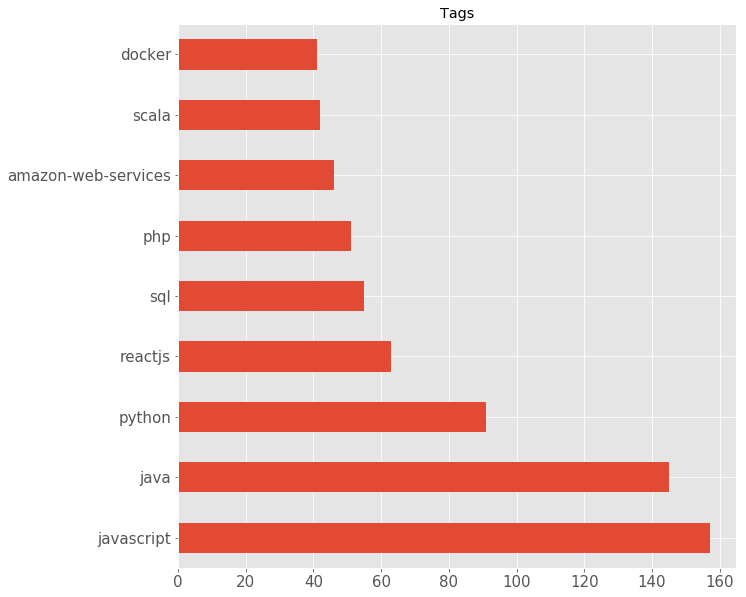

In [101]:
most_common_tags.plot(kind='barh', figsize=(10,10), fontsize=15, title="Tags")

Now want to consider the each job offer, without considering tags, so they must be unique.

In [102]:
grouped = df_2.drop(["tag"], axis=1)
grouped = grouped.drop_duplicates()

In [103]:
grouped.head()

,id,content,title,link,updated_on,published_on,slug,company
0,68396,<p>MEDWING is building an end-to-end staffing ...,Ruby on Rails DevOp Engineer (m/f) // MEDWING,http://berlinstartupjobs.com/engineering/ruby-...,2017-10-11 13:31:20,2017-10-11 14:15:18,ruby-on-rails-devop-engineer-mf-medwing,MEDWING
1,68390,<p>We are looking for a highly motivated Syste...,System Administrator (f/m) // Modomoto (Curate...,http://berlinstartupjobs.com/engineering/syste...,2017-10-11 13:20:52,2017-10-11 13:43:16,system-administrator-fm-modomoto-curated-shopp...,Modomoto (Curated Shopping GmbH)
2,68376,<p>Join our amazing development team and help ...,Senior Frontend Engineer // IDAGIO,http://berlinstartupjobs.com/engineering/senio...,2017-10-11 12:58:05,2017-10-11 13:33:00,senior-frontend-engineer-idagio,IDAGIO
3,68392,<p>Panono develops trend-setting digital camer...,SENIOR BACKEND ENGINEER // Panono,http://berlinstartupjobs.com/engineering/senio...,2017-10-11 13:25:40,2017-10-11 13:25:40,senior-backend-engineer-panono,Panono
4,68354,<p>Get the unique opportunity to leave your ma...,Lead Frontend Engineer // Loopline Systems,http://berlinstartupjobs.com/engineering/lead-...,2017-10-11 12:53:38,2017-10-11 13:02:53,lead-frontend-engineer-loopline-systems,Loopline Systems


In [104]:
sorted_number_offers = grouped.groupby("company")['id'].count().sort_values(ascending=False)

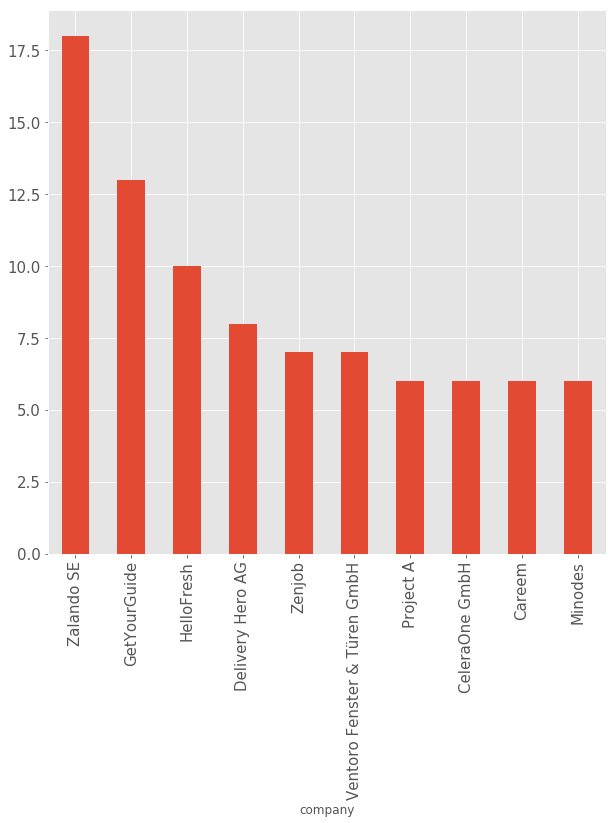

In [105]:
# first 10 companies with most job offers
sorted_number_offers[:10].plot(kind='bar', figsize=(10,10), fontsize=15)

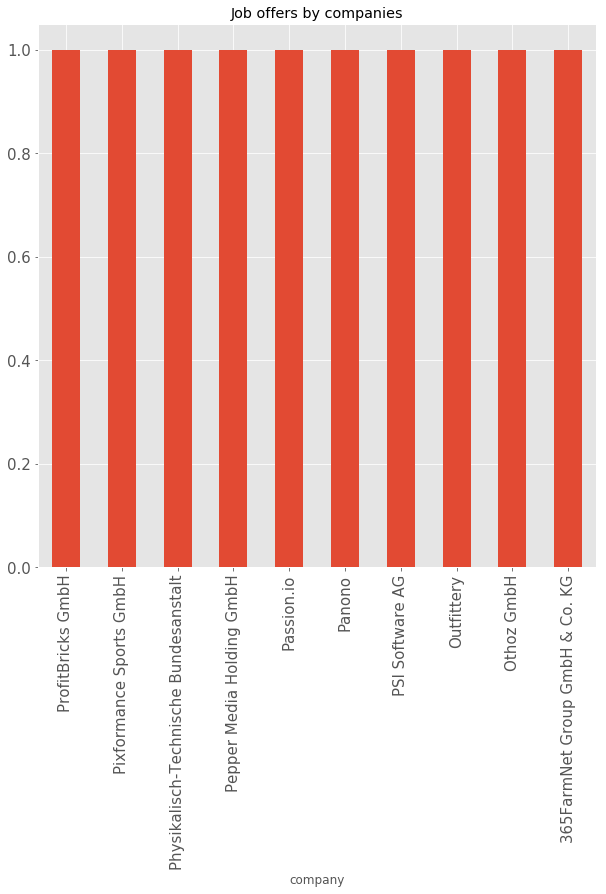

In [106]:
# last 10 companies per number of job offers
sorted_number_offers[-10:].plot(kind='bar', figsize=(10,10), title="Job offers by companies", fontsize=15)

In [107]:
grouped['weekday'] = grouped['published_on'].dt.dayofweek

In [108]:
grouped.head()

,id,content,title,link,updated_on,published_on,slug,company,weekday
0,68396,<p>MEDWING is building an end-to-end staffing ...,Ruby on Rails DevOp Engineer (m/f) // MEDWING,http://berlinstartupjobs.com/engineering/ruby-...,2017-10-11 13:31:20,2017-10-11 14:15:18,ruby-on-rails-devop-engineer-mf-medwing,MEDWING,2
1,68390,<p>We are looking for a highly motivated Syste...,System Administrator (f/m) // Modomoto (Curate...,http://berlinstartupjobs.com/engineering/syste...,2017-10-11 13:20:52,2017-10-11 13:43:16,system-administrator-fm-modomoto-curated-shopp...,Modomoto (Curated Shopping GmbH),2
2,68376,<p>Join our amazing development team and help ...,Senior Frontend Engineer // IDAGIO,http://berlinstartupjobs.com/engineering/senio...,2017-10-11 12:58:05,2017-10-11 13:33:00,senior-frontend-engineer-idagio,IDAGIO,2
3,68392,<p>Panono develops trend-setting digital camer...,SENIOR BACKEND ENGINEER // Panono,http://berlinstartupjobs.com/engineering/senio...,2017-10-11 13:25:40,2017-10-11 13:25:40,senior-backend-engineer-panono,Panono,2
4,68354,<p>Get the unique opportunity to leave your ma...,Lead Frontend Engineer // Loopline Systems,http://berlinstartupjobs.com/engineering/lead-...,2017-10-11 12:53:38,2017-10-11 13:02:53,lead-frontend-engineer-loopline-systems,Loopline Systems,2


In [109]:
grouped_by_day = grouped.groupby("weekday")['id'].count()

In [110]:
grouped_by_day

weekday
0     97
1     83
2    112
3    128
4    121
5     54
6     36
Name: id, dtype: int64

In [111]:
grouped_by_day.index = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

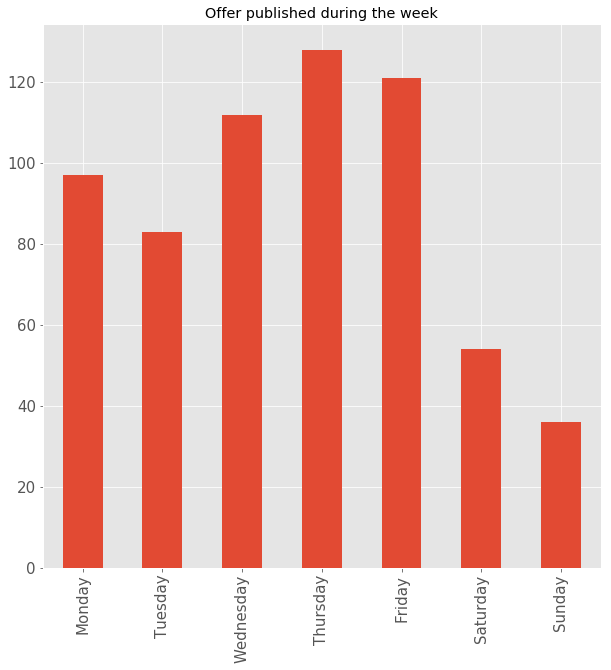

In [112]:
grouped_by_day.plot(kind='bar', figsize=(10,10), title="Offer published during the week", fontsize=15)

In [113]:
dt_df = grouped.set_index("published_on").loc[:,["id"]].resample('D', label="published_on").count()

In [114]:
dt_df.describe()

,id
count,52.000000
mean,12.134615
std,7.241029
min,0.000000
25%,7.000000
50%,13.000000
75%,17.250000
max,28.000000


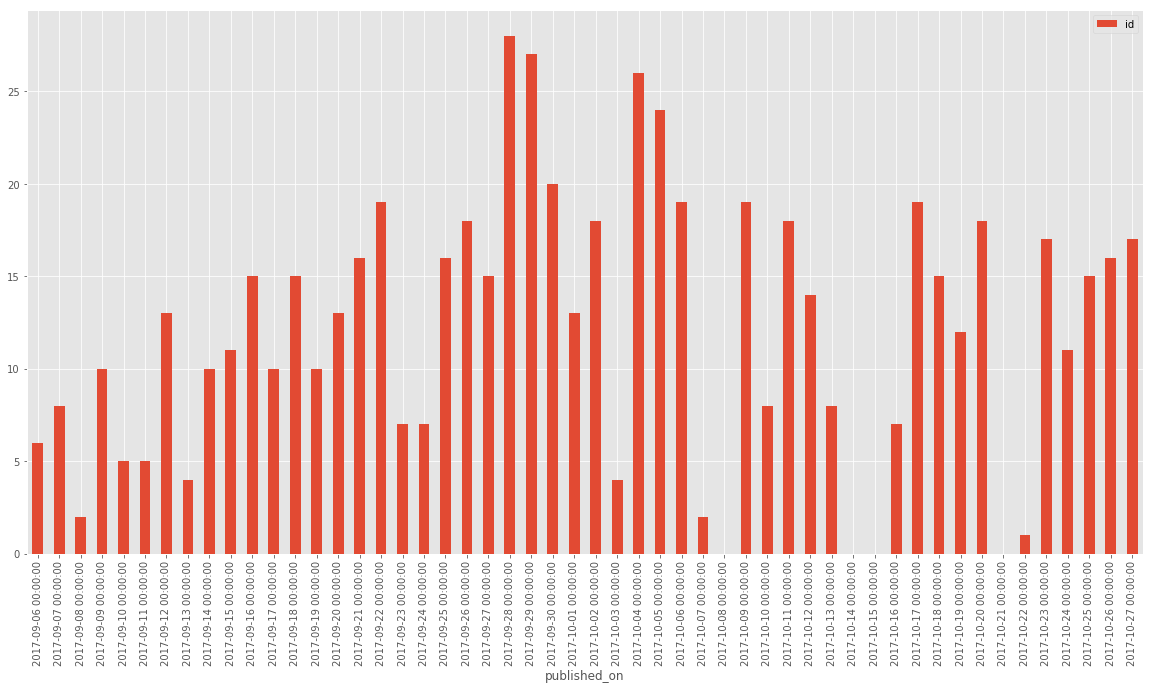

In [115]:
dt_df.plot(kind="bar", figsize=(20,10))

<div class="alert alert-success">
    <b>Exercise:</b> Can you find the most Pythonic companies?
</div>

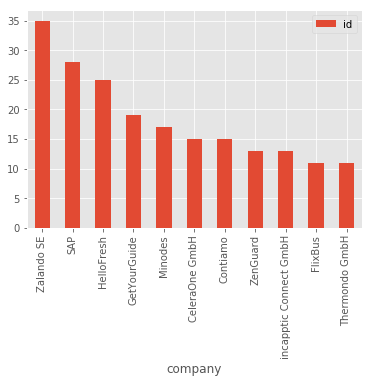

In [116]:
python_offers = df_2.loc[df_2.content.str.contains("python", case=False)]
pythonic_companies = python_offers.groupby("company")[["id"]].count()
pythonic_companies[pythonic_companies["id"] >10].sort_values(by="id", ascending=False).plot(kind="bar")

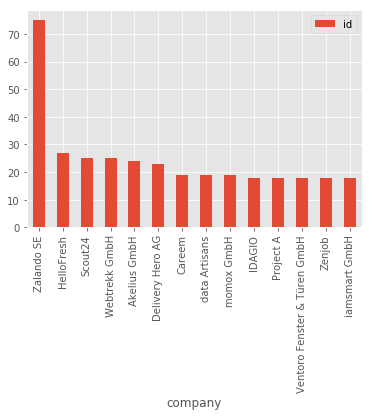

In [117]:
java_offers = df_2.loc[df_2.content.str.contains("java", case=False)]
java_companies = java_offers.groupby("company")[["id"]].count()
java_companies[java_companies["id"] >15].sort_values(by="id", ascending=False).plot(kind="bar")

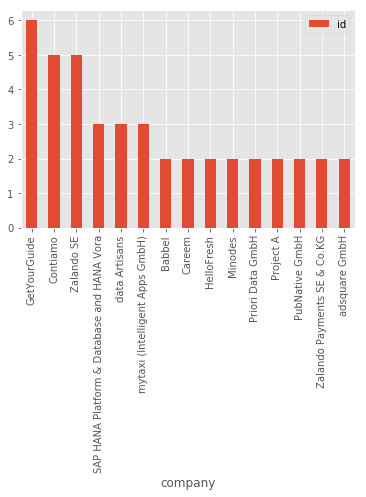

In [118]:
data_offers = grouped.loc[df_2.title.str.contains("data", case=False)]
data_companies = data_offers.groupby("company")[["id"]].count()
data_companies[data_companies["id"] >=2].sort_values(by="id", ascending=False).plot(kind="bar")

In [119]:
offer_description = grouped.loc[grouped.content.str.contains("docker", case=False)][["company", "content" ]]

In [120]:
len_descriptions = offer_description['content'].apply(len)

In [132]:
len_descriptions[len_descriptions > 4500]

35     4613
143    5773
235    4742
243    4765
250    4703
278    4693
409    5129
558    5316
577    6272
594    5421
621    4728
623    5320
Name: content, dtype: int64

In [135]:
from IPython.display import display, HTML
chart = HTML(offer_description.loc[35,:]['content'])
display(chart)